In [1]:
import os
import argparse
import time
import glob
import pickle
import subprocess
import shlex
import io
import pprint
import importlib
from urllib.request import urlopen
from IPython.display import Image as dispImg
import scipy.io
import numpy as np
import pandas
import tqdm
import fire
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.model_zoo
import torchvision
from art.classifiers import PyTorchClassifier
import cornet
from art.attacks import BoundaryAttack
from art.attacks import HopSkipJump
from imgaug import augmenters as iaa
import imgaug as ia
#attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
from art.attacks import FastGradientMethod
from art.attacks import ElasticNet
from art.attacks import ProjectedGradientDescent

from PIL import Image
Image.warnings.simplefilter('ignore')

ia.seed(1)
np.random.seed(0)
torch.manual_seed(0)

mean = torch.tensor([0.44, 0.44, 0.44], dtype=torch.float32)
std = torch.tensor([0.225, 0.225, 0.225], dtype=torch.float32)
normalize = torchvision.transforms.Normalize(mean=[0.44, 0.44, 0.44],
                                             std=[0.225, 0.225, 0.225])
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                normalize
            ])
unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def get_model(model_size='z', cuda=False):
    map_location = 'cpu' if not cuda else None
    #map_location = None
    model = getattr(cornet, f'cornet_{model_size.lower()}')
    if model_size.lower() == 'r':
        model = model(pretrained=True, map_location=map_location, times=5)
    else:
        model = model(pretrained=True, map_location=map_location)
    if cuda:
        model = model.cuda()
        return model
    model.cpu()
    return model.module

sharpen = iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), deterministic=True)


                # Same as sharpen, but for an embossing effect.
emboss = iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0), deterministic=True)


Load data

In [2]:
labels = pickle.load(open("labels.pkl", "rb" ))
y_val = np.load("D:\\imagenet2012\\y_val.npy")
print(f"{y_val.shape[0]} validation labels loaded")
data_path = 'D:\\imagenet2012\\val'
fnames = sorted(glob.glob(os.path.join(data_path, '*.*')))
print(f"{len(fnames)} files found");

50000 validation labels loaded
50000 files found


In [3]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [4]:
np.argsort((y_val == 26))[-2]

48045

In [5]:
def get_image_by_class(image_class):
    return Image.open(fnames[np.argsort((y_val == image_class))[-1]]).convert('RGB')

In [6]:
def plot_augmented(original_image, adv_image):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
    axes[0, 0].imshow(to_grayscale(original_image))
    axes[0, 1].imshow(to_grayscale(adv_image))
    axes[1, 0].imshow(to_grayscale(sharpen.augment_image(original_image)))
    axes[1, 1].imshow(to_grayscale(sharpen.augment_image(adv_image)))
    axes[2, 0].imshow(to_grayscale(emboss.augment_image(original_image)))
    axes[2, 1].imshow(to_grayscale(emboss.augment_image(adv_image)))
    plt.show()

In [7]:
def l2(orig, adv):
    return np.linalg.norm(np.reshape(adv[0] - orig[0], [-1]))

In [17]:
def perform_attack(im, model_size, target_class=None, targeted=False, show_info=True, params={'max_iter': 300}):
    model = get_model(model_size)
    model.eval()
    if show_info:
        print(f'using model type: {model_size}')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                               optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    attack = ProjectedGradientDescent(classifier=classifier, targeted=targeted, **params)
    
    x = transform(im).unsqueeze(0).numpy()
    
    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    if show_info:
        top_5 = np.flip(np.argsort(pred)[-5:])
        print('\nOriginal image predictions:')
        for t in top_5:
            print(f'{labels[t]} ({t}): {pred[t]}')
        print('\nGenerating adversarial example')
    
    x_adv = attack.generate(x=transform(im).unsqueeze(0).numpy(), y=np.array([target_class]) if target_class is not None else None)
    if show_info:
        print('L2: ' + str(np.linalg.norm(np.reshape(x_adv[0] - x[0], [-1]))))
    
    original_image = np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    adv_image = np.moveaxis(unnormalize(torch.from_numpy(x_adv[0])).numpy(),  [0, 1, 2], [2, 0, 1])
    pert = np.abs(adv_image - original_image)[..., ::-1]
    pert_min = np.min(pert)
    pert_max = np.max(pert)
    pert_image = -((pert - pert_min) / (pert_max - pert_min))+1
    if show_info:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
        axes[0].imshow(original_image)
        axes[1].imshow(pert_image)
        axes[2].imshow(adv_image)
    
    adv_pred = classifier.predict(x_adv)[0]
    adv_pred = np.exp(adv_pred)/sum(np.exp(adv_pred))
    if show_info:
        top_5 = np.flip(np.argsort(adv_pred)[-5:])
        print('\nAdversarial image predictions:')
        for t in top_5:
            print(f'{labels[t]} ({t}): {adv_pred[t]}')
    
    plt.show()
    return adv_pred

In [9]:
i=39218
print(labels[y_val[i]])
#target 39206

magpie


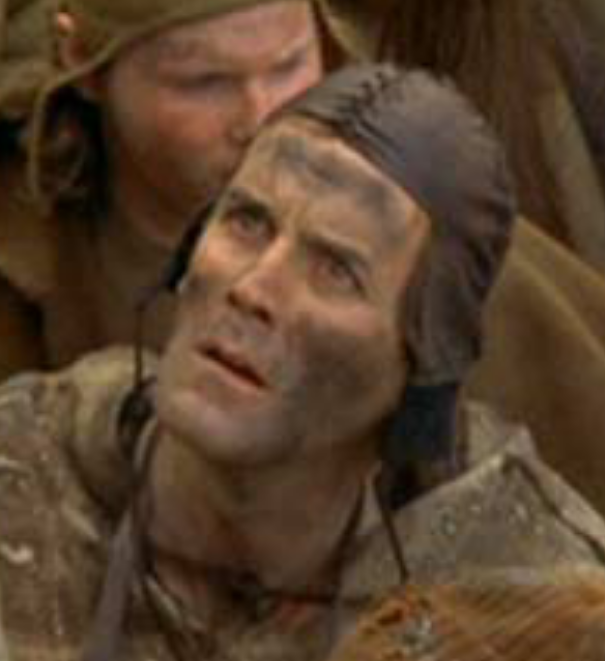

In [9]:
#im = Image.open(fnames[i]).convert('RGB')
#im = Image.open("D:\\imagenet2012\junco.jpg").convert('RGB')
im = Image.open("D:\\imagenet2012\john_cleese.png").convert('RGB')
#im = Image.open(fnames[np.argsort((y_val == 26))[-3]]).convert('RGB')
im

In [10]:
def get_classifier(model_size='z'):
    model = get_model(model_size)
    model.eval()
    print(f'using model type: {model_size}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    classifier = PyTorchClassifier(model=model, loss=criterion,
                                   optimizer=optimizer, nb_classes=1000, input_shape=(3,224,224), clip_values=(-1.956, 6.4))
    return classifier

In [11]:
z = get_classifier()
s = get_classifier('s')
    


using model type: z
using model type: s


In [12]:
def predict(classifier, im, show_info=True):

    x = transform(im).unsqueeze(0).numpy()

    pred = classifier.predict(x)[0]
    pred = np.exp(pred)/sum(np.exp(pred))
    if show_info:
        top_5 = np.flip(np.argsort(pred)[-5:])
        print('\nOriginal image predictions:')
        for t in top_5:
            print(f'{labels[t]} ({t}): {pred[t]}')

            plt.imshow(np.moveaxis(unnormalize(torch.from_numpy(x[0])).numpy(),  [0, 1, 2], [2, 0, 1]))
            plt.show()
    return pred

In [13]:
def random_exclude(high, exclude=[]):
    tries_left = 5
    while tries_left > 1:
        num = np.random.randint(high)
        tries_left -= 1
        if num not in exclude:
            return num
    raise Exception('Could not generate random number')

In [14]:
images_used = []
targets = []
fooled_s = []
fooled_z = [] 
confused_z = []
confused_s = []
#500 iter
while len(images_used) < 10:
    
    random_int = np.random.randint(50000)
    if random_int in images_used:
        continue
    im = Image.open(fnames[random_int]).convert('RGB')
    true_label = y_val[random_int]
    
    pred_z = predict(z, im, False)
    label_z = np.argmax(pred_z)
    if true_label != label_z or pred_z[label_z] < 0.5:
        continue
    pred_s = predict(s, im, False)
    label_s = np.argmax(pred_s)
    if true_label != label_s or pred_s[label_s] < 0.5:
        continue
    #images are correctly recognized before attacks
    images_used.append(random_int)
    
    target = random_exclude(1000, [true_label])
    targets.append(target)
    
    adv_z = perform_attack(im, 'z', target, True, show_info=False)
    adv_s = perform_attack(im, 's', target, True, show_info=False)
    
    adv_class_z = np.argmax(adv_z)
    adv_class_s = np.argmax(adv_s)
    
    fooled_z.append(target == adv_class_z and adv_z[adv_class_z] >= 0.5)
    fooled_s.append(target == adv_class_s and adv_s[adv_class_s] >= 0.5)
    confused_z.append(adv_class_z != true_label)
    confused_s.append(adv_class_s != true_label)
    
    print('Fooled z:')
    print(np.array(fooled_z).sum())
    print('Fooled s:')
    print(np.array(fooled_s).sum())
    print(f'images processed: {len(images_used)}')

print('Fooled z %:')
print(np.array(fooled_z).sum() / len(images_used) * 100)
print('Fooled s %:')
print(np.array(fooled_s).sum() / len(images_used) * 100)


print('Confused z %:')
print(np.array(confused_z).sum() / len(images_used) * 100)
print('Confused s %:')
print(np.array(confused_s).sum() / len(images_used) * 100)

Fooled z:
1
Fooled s:
1
images processed: 1
Fooled z:
2
Fooled s:
1
images processed: 2
Fooled z:
3
Fooled s:
1
images processed: 3
Fooled z:
4
Fooled s:
2
images processed: 4
Fooled z:
5
Fooled s:
3
images processed: 5
Fooled z:
6
Fooled s:
4
images processed: 6
Fooled z:
7
Fooled s:
5
images processed: 7
Fooled z:
8
Fooled s:
6
images processed: 8
Fooled z:
9
Fooled s:
6
images processed: 9
Fooled z:
10
Fooled s:
7
images processed: 10
Fooled z:
11
Fooled s:
8
images processed: 11
Fooled z:
12
Fooled s:
9
images processed: 12
Fooled z:
13
Fooled s:
10
images processed: 13
Fooled z:
14
Fooled s:
11
images processed: 14
Fooled z:
15
Fooled s:
12
images processed: 15
Fooled z:
16
Fooled s:
12
images processed: 16
Fooled z:
17
Fooled s:
13
images processed: 17
Fooled z:
18
Fooled s:
14
images processed: 18
Fooled z:
19
Fooled s:
15
images processed: 19
Fooled z:
20
Fooled s:
16
images processed: 20
Fooled z:
21
Fooled s:
17
images processed: 21
Fooled z:
22
Fooled s:
18
images processed:

In [16]:
images_used = []
targets = []
fooled_s = []
fooled_z = [] 
confused_z = []
confused_s = []
#1000 maxiter
while len(images_used) < 10:
    
    random_int = np.random.randint(50000)
    if random_int in images_used:
        continue
    im = Image.open(fnames[random_int]).convert('RGB')
    true_label = y_val[random_int]
    
    pred_z = predict(z, im, False)
    label_z = np.argmax(pred_z)
    if true_label != label_z or pred_z[label_z] < 0.5:
        continue
    pred_s = predict(s, im, False)
    label_s = np.argmax(pred_s)
    if true_label != label_s or pred_s[label_s] < 0.5:
        continue
    #images are correctly recognized before attacks
    images_used.append(random_int)
    
    target = random_exclude(1000, [true_label])
    targets.append(target)
    
    adv_z = perform_attack(im, 'z', target, True, show_info=False)
    adv_s = perform_attack(im, 's', target, True, show_info=False)
    
    adv_class_z = np.argmax(adv_z)
    adv_class_s = np.argmax(adv_s)
    
    fooled_z.append(target == adv_class_z and adv_z[adv_class_z] >= 0.5)
    fooled_s.append(target == adv_class_s and adv_s[adv_class_s] >= 0.5)
    confused_z.append(adv_class_z != true_label)
    confused_s.append(adv_class_s != true_label)
    
    print('Fooled z:')
    print(np.array(fooled_z).sum())
    print('Fooled s:')
    print(np.array(fooled_s).sum())
    print(f'images processed: {len(images_used)}')

print('Fooled z %:')
print(np.array(fooled_z).sum() / len(images_used) * 100)
print('Fooled s %:')
print(np.array(fooled_s).sum() / len(images_used) * 100)


print('Confused z %:')
print(np.array(confused_z).sum() / len(images_used) * 100)
print('Confused s %:')
print(np.array(confused_s).sum() / len(images_used) * 100)

Fooled z:
1
Fooled s:
1
images processed: 1
Fooled z:
2
Fooled s:
1
images processed: 2
Fooled z:
3
Fooled s:
1
images processed: 3
Fooled z:
4
Fooled s:
2
images processed: 4
Fooled z:
5
Fooled s:
3
images processed: 5
Fooled z:
6
Fooled s:
4
images processed: 6
Fooled z:
7
Fooled s:
5
images processed: 7
Fooled z:
8
Fooled s:
5
images processed: 8
Fooled z:
8
Fooled s:
6
images processed: 9
Fooled z:
9
Fooled s:
6
images processed: 10
Fooled z %:
90.0
Fooled s %:
60.0
Confused z %:
100.0
Confused s %:
100.0


In [19]:
images_used = []
targets = []
fooled_s = []
fooled_z = [] 
confused_z = []
confused_s = []

while len(images_used) < 100:
    
    random_int = np.random.randint(50000)
    if random_int in images_used:
        continue
    im = Image.open(fnames[random_int]).convert('RGB')
    true_label = y_val[random_int]
    
    pred_z = predict(z, im, False)
    label_z = np.argmax(pred_z)
    if true_label != label_z or pred_z[label_z] < 0.5:
        continue
    pred_s = predict(s, im, False)
    label_s = np.argmax(pred_s)
    if true_label != label_s or pred_s[label_s] < 0.5:
        continue
    #images are correctly recognized before attacks
    images_used.append(random_int)
    
    target = random_exclude(1000, [true_label])
    targets.append(target)
    
    adv_z = perform_attack(im, 'z', target, True, show_info=False)
    adv_s = perform_attack(im, 's', target, True, show_info=False)
    
    adv_class_z = np.argmax(adv_z)
    adv_class_s = np.argmax(adv_s)
    
    fooled_z.append(target == adv_class_z and adv_z[adv_class_z] >= 0.5)
    fooled_s.append(target == adv_class_s and adv_s[adv_class_s] >= 0.5)
    confused_z.append(adv_class_z != true_label)
    confused_s.append(adv_class_s != true_label)
    
    print('Fooled z:')
    print(np.array(fooled_z).sum())
    print('Fooled s:')
    print(np.array(fooled_s).sum())
    print(f'images processed: {len(images_used)}')

print('Fooled z %:')
print(np.array(fooled_z).sum() / len(images_used) * 100)
print('Fooled s %:')
print(np.array(fooled_s).sum() / len(images_used) * 100)


print('Confused z %:')
print(np.array(confused_z).sum() / len(images_used) * 100)
print('Confused s %:')
print(np.array(confused_s).sum() / len(images_used) * 100)

Fooled z:
1
Fooled s:
1
images processed: 1
Fooled z:
2
Fooled s:
2
images processed: 2
Fooled z:
3
Fooled s:
3
images processed: 3
Fooled z:
4
Fooled s:
4
images processed: 4
Fooled z:
5
Fooled s:
5
images processed: 5
Fooled z:
6
Fooled s:
6
images processed: 6
Fooled z:
7
Fooled s:
7
images processed: 7
Fooled z:
8
Fooled s:
8
images processed: 8
Fooled z:
9
Fooled s:
9
images processed: 9
Fooled z:
10
Fooled s:
10
images processed: 10
Fooled z:
11
Fooled s:
10
images processed: 11
Fooled z:
12
Fooled s:
11
images processed: 12
Fooled z:
13
Fooled s:
12
images processed: 13
Fooled z:
14
Fooled s:
13
images processed: 14
Fooled z:
15
Fooled s:
14
images processed: 15
Fooled z:
16
Fooled s:
15
images processed: 16
Fooled z:
17
Fooled s:
16
images processed: 17
Fooled z:
18
Fooled s:
17
images processed: 18
Fooled z:
19
Fooled s:
18
images processed: 19
Fooled z:
20
Fooled s:
19
images processed: 20
Fooled z:
21
Fooled s:
20
images processed: 21
Fooled z:
22
Fooled s:
21
images process